Домашняя работа к лекции 1 по курсу Временные ряды.
---------
**Временные ряды, общая теория**

Студента: **Помойницкого Евгения**

Группа: **DS 8**

Задание
---
Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error

Возьмем готовые функции из материалов лекции

In [54]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()


In [55]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return pd.Series([np.NaN]).append(wma, ignore_index=True)

In [56]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [57]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

Для сокрашения количества кода определим функцию для рисования графиков оригинального ряда и его приближения.

In [58]:
def plot_approximation(series, approx, title):
    """Plots original timeseries and given approximation. Takes series, pre-calculated approxiamtion series,
    title of the plot as string"""
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, c='b', label='Original')
        plt.plot(approx, color='red', linewidth='2', label='Approximation')
        plt.title(title)
        plt.legend()

Возьмем в качестве **первого ряда** данные об ограблениях в оригинальном виде (без преобразования к стационарному виду)

In [78]:
series = pd.read_csv('../Series/monthly-boston-armed-robberies-j.csv')
series = pd.Series(series['Count'])
series[:10]

0    41
1    39
2    50
3    40
4    43
5    38
6    44
7    35
8    39
9    35
Name: Count, dtype: int64

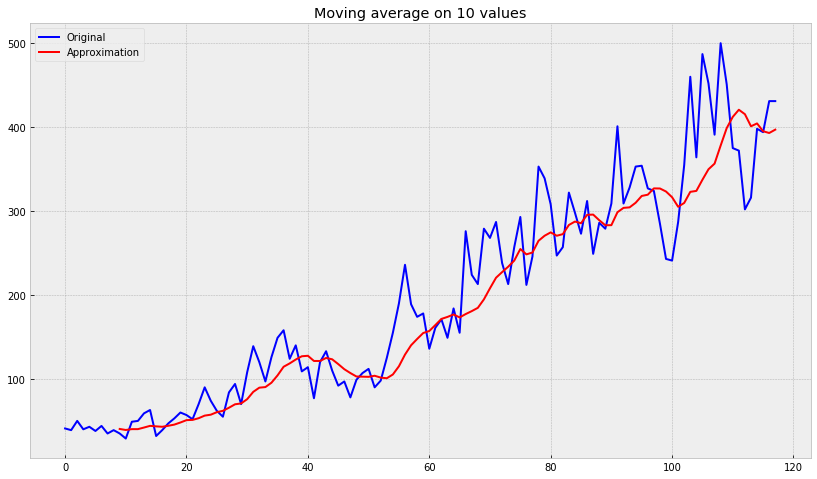

In [82]:
approx = moving_average(series, 10)

plot_approximation(series, approx, 'Moving average on 10 values')

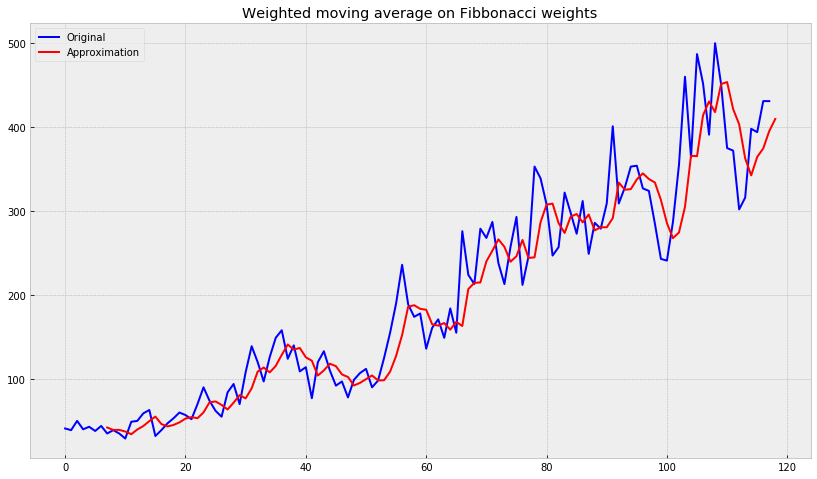

In [39]:
fib = [1,1,2,3,5,8,13]
approx = weighted_moving_average(series, 7, fib)

plot_approximation(series, approx, 'Weighted moving average on Fibbonacci weights')

Для методов, дающих значения аппроксимированных рядов попробуем, кроме визуальной оценки, применить численную оценку точности на основе среднеквадратичной ошибки. Само по себе ее значение не будет особо информативно для ряда с трендом, поскольку значение ошибки будет больше определяться большими значениями конца ряда. Но в качестве метрики сравнения двух аппроксимаций может подойти (опять же, с учетом влияния значений ряда).

Mean squared error of approximation to original series is 390.95665608378437


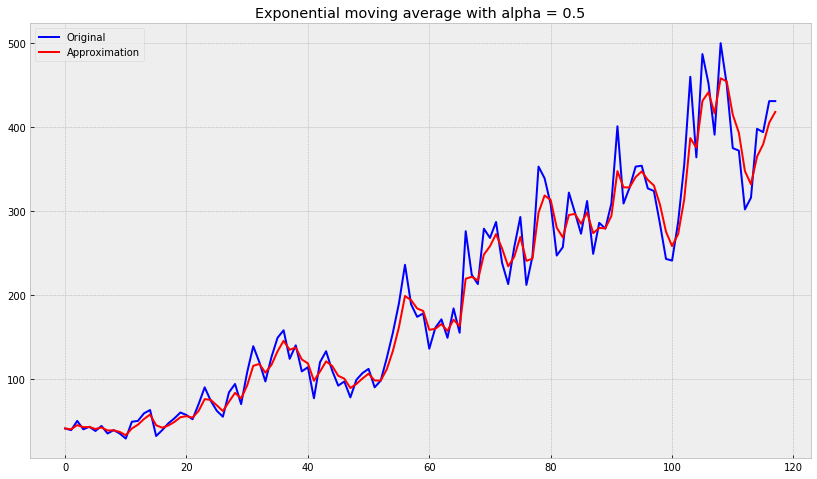

In [68]:
alpha = 0.5
approx = exponential_moving_average(series, alpha)

print('Mean squared error of approximation to original series is {}'.format(mean_squared_error(approx, series)))

plot_approximation(series, approx, 'Exponential moving average with alpha = 0.5')

Mean squared error of approximation to original series is 414.13923774052495


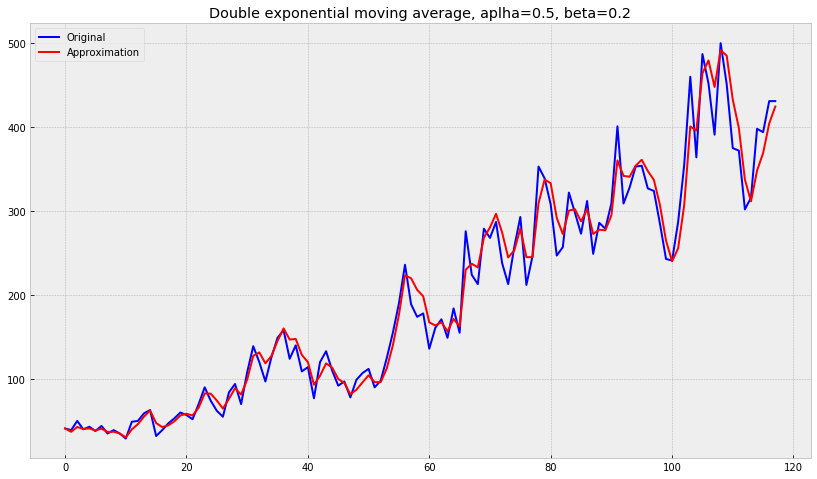

In [69]:
alpha, beta = 0.5, 0.2
approx = double_ema(series, alpha, beta)

print('Mean squared error of approximation to original series is {}'.format(mean_squared_error(approx, series)))

plot_approximation(series, approx, 'Double exponential moving average, aplha=0.5, beta=0.2')

Видно, что наиболее простые методы дают нихудшее приближение, тогда как более продвинутые вполне хорошо соответсвуют ряду.

Сравнивать между собой результаты экспоненциального сглаживания и двойного эспоненциального сглаживания не очень просто. Если принять корректность применения MSE, то простое экспоненциальное сглаживание дало более качественное приближение к оригинальному ряду. 

В качестве **второго ряда** возьмем тот же ряд, но только после преобразований к стационарному виду согласно ДЗ 1. Для его приведения к стационарности мы применяли преобразование Бокса-Кокса, а затем дифференцировали с лагом 1

In [83]:
series = boxcox(series, 0)

series = series[1:] - series[:-1]

Проверку стационарности после преобразований мы выполняли в ДЗ 1.

Теперь, собственно, применим те же методы аппроксимации к стационарному ряду.

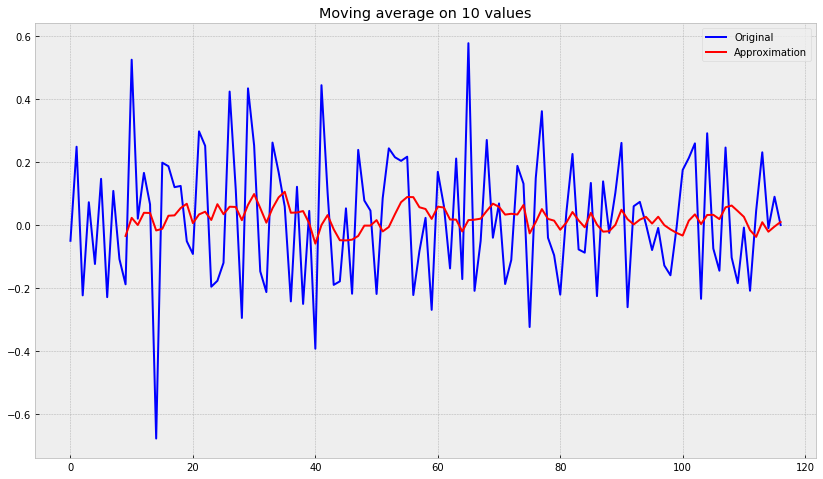

In [84]:
approx = moving_average(series, 10)

plot_approximation(series, approx, 'Moving average on 10 values')

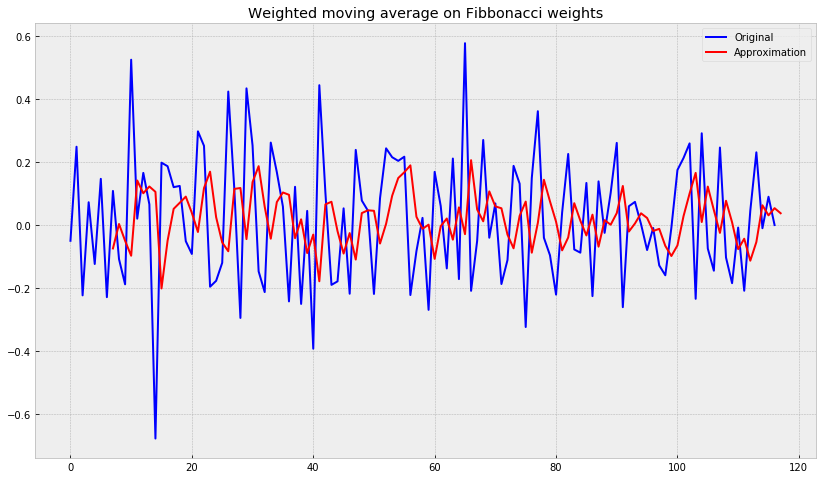

In [85]:
fib = [1,1,2,3,5,8,13]
approx = weighted_moving_average(series, 7, fib)

plot_approximation(series, approx, 'Weighted moving average on Fibbonacci weights')

Mean squared error of approximation to original series is 0.01642752747841851


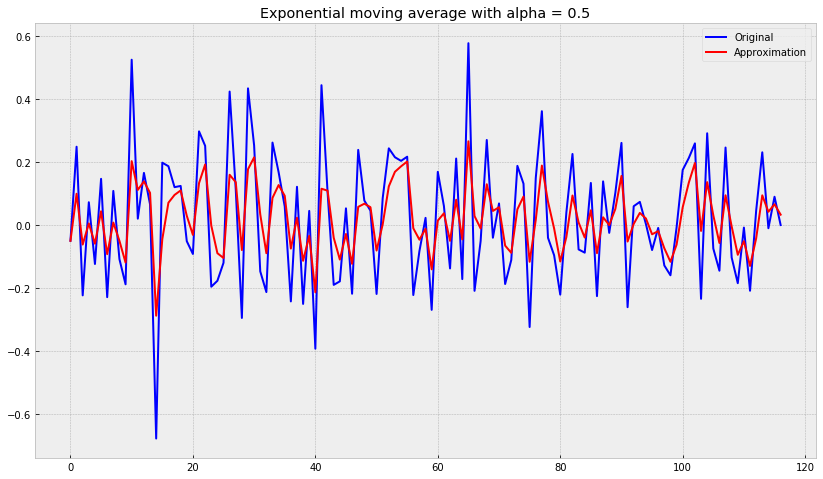

In [86]:
alpha = 0.5
approx = exponential_moving_average(series, alpha)

print('Mean squared error of approximation to original series is {}'.format(mean_squared_error(approx, series)))
plot_approximation(series, approx, 'Exponential moving average with alpha = 0.5')

Mean squared error of approximation to original series is 0.02255755860178172


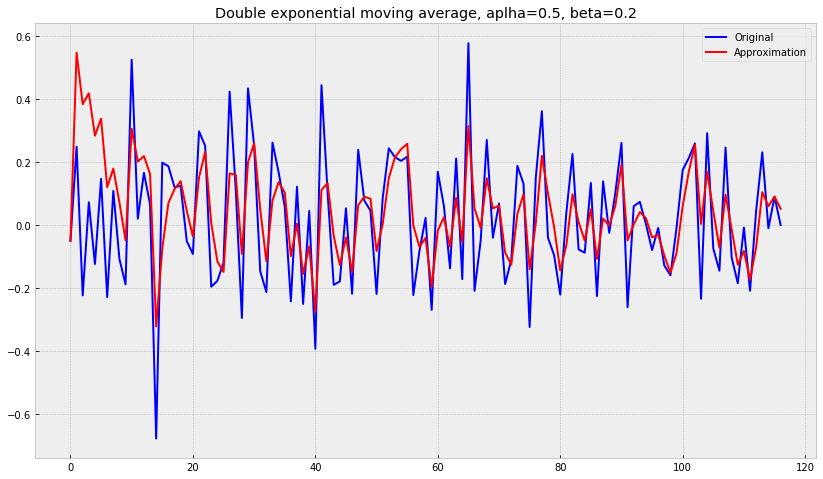

In [87]:
alpha, beta = 0.5, 0.2
approx = double_ema(series, alpha, beta)

print('Mean squared error of approximation to original series is {}'.format(mean_squared_error(approx, series)))
plot_approximation(series, approx, 'Double exponential moving average, aplha=0.5, beta=0.2')

Для ряда в стационарной форме самые простые методы дали, предсказуемо, самое слабое приближение. Но и более продвинутые методы ведут себя тоже не блестяще. Для ряда в нестационарном виде, визуально оценивая графики, точность была выше.

Значения метрики MSE для экспоненциальных сглаживаний можно принять обоснованным, если посмотреть на графики более детально - двойное экспоненциальное сглаживание дало очень грубый скачок в начале ряда.